**Implementation of XGBoost Classifier for Trash Image Classification**.

Msc Theses Project
Submitted by Himanshu Gupta (x18203302)

In [1]:
# Install XGBoost if not avaialble
!sudo pip install xgboost
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
# Data Processing 
import os
import os.path
import random
import PIL
from PIL import Image # to read images
# Import XGBoost
import xgboost as xgb
# Import image pre processor from keras
from keras.preprocessing import image
from sklearn import metrics
from sklearn.model_selection import train_test_split
np.random.seed(1337)  # for reproducibility

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**Set Data Directories Path**

In [4]:
# Initial Dataset Path
initial_data_path = "/content/drive/My Drive/data/"
initial_data_csv_path = "/content/drive/My Drive/InitialData.csv"
modelB_csv_path = "/content/drive/My Drive/saved_model/modelB/"

# Augmented Data Path
data_path = "/content/drive/My Drive/trainDataTACO/"
final_data_csv_path = "/content/drive/My Drive/FinalData.csv"
save_csv_path = "/content/drive/My Drive/saved_model/modelAug/"

In [5]:
# Create Pandas DataFrame
print("Dataframe 1")
df1 = pd.read_csv(initial_data_csv_path)
df1 = df1.drop(['x_min','x_max','y_min','y_max'], axis=1)
print(df1.info()) 
print()
print("Dataframe 2")
df2 = pd.read_csv(final_data_csv_path)
print(df2.info())

Dataframe 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  805 non-null    object
 1   category  805 non-null    object
dtypes: object(2)
memory usage: 12.7+ KB
None

Dataframe 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3442 entries, 0 to 3441
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  3442 non-null   object
 1   filename  3442 non-null   object
dtypes: object(2)
memory usage: 53.9+ KB
None


In [6]:
# Parameters
xgb_params = {'num_class':5, # Number of Output classes
              'nthread':8, # Number of Parallel threads
              'gamma':0.1, # For minimizing loss 
              'eval_metric':'mlogloss', # Multi classification evaluation 
              'min_child_weight':3, # It performs regularization
              'subsample':0.7, # Percentage of rows consider while building subtree 
              'max_depth': 16, # Maximum number of nodes between root and farthest leaf
              'objective': 'multi:softmax', # Multi label classification
              'seed': 1337, # For reproducibility
              'silent': True}

## **XGBoost Classification Model Base**

In [ ]:
if len(train_data) == 0:
  # Generate array data
  train_data = []  
  for ind in df1.index:
      img = Image.open(os.path.join(initial_data_path + df1['filename'][ind]))
      img = img.resize((128, 128), Image.ANTIALIAS)
      img = image.img_to_array(img)
      # Append image
      train_data.append(img)
  X1 = np.array(train_data)
  print("Image Array Data Created")

Image Array Data Created


In [ ]:
# Convert labels into categorical classes
df1['category'] = df1['category'].astype('category')
df1['category'] = df1['category'].cat.codes

In [ ]:
# Drop file names and create Labels array
Y1 = np.array(df1.drop(['filename'],axis=1))

In [ ]:
# Data split Randomly
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, random_state=1337, test_size=0.2)
x_train = x_train.reshape(-1, 128*128*3) / 255.      # normalize data
x_test = x_test.reshape(-1, 128*128*3) / 255.        # normalize data

print("Train data shape")
print(x_train.shape)
print(y_train.shape)
print("Test data shape")
print(x_test.shape)
print(y_test.shape)

Train data shape
(644, 49152)
(644, 1)
Test data shape
(161, 49152)
(161, 1)


In [ ]:
if len(os.listdir(modelB_csv_path)) == 0:
  #Save Train Data into CSV
  z1 = np.concatenate([np.array(x_train).reshape(644,49152),np.array(y_train).reshape(644,1)],axis=1)
  z1 = pd.DataFrame(z1)
  z1.to_csv(modelB_csv_path +'train_xg_1.csv',index=False)
  #Save Test Data into CSV
  z1 = np.concatenate([np.array(x_test).reshape(161,49152),np.array(y_test).reshape(161,1)],axis=1)
  z1 = pd.DataFrame(z1)
  z1.to_csv(modelB_csv_path +'test_xg_1.csv',index=False)
  print("CSV Files Saved")
else:    
  print("Directory is not empty")

CSV Files Saved


In [ ]:
data1 = pd.read_csv(modelB_csv_path +'train_xg_1.csv')
# Create Target variables
train_Y = data1['49152'].astype('int')
train_X = data1.drop(['49152'],axis=1)

In [ ]:
# Generate optimized data structure for XGBoost
dataset1 = xgb.DMatrix(train_X, label=train_Y)
watchlist = [(dataset1, 'train')]
model_B = xgb.train(xgb_params, dataset, num_boost_round=100, evals=watchlist, maximize=True)

[0]	train-mlogloss:1.33683
[1]	train-mlogloss:1.10716
[2]	train-mlogloss:0.936602
[3]	train-mlogloss:0.794226
[4]	train-mlogloss:0.677074
[5]	train-mlogloss:0.577685
[6]	train-mlogloss:0.498189
[7]	train-mlogloss:0.431848
[8]	train-mlogloss:0.375272
[9]	train-mlogloss:0.331026
[10]	train-mlogloss:0.291982
[11]	train-mlogloss:0.25935
[12]	train-mlogloss:0.232453
[13]	train-mlogloss:0.20874
[14]	train-mlogloss:0.189084
[15]	train-mlogloss:0.172431
[16]	train-mlogloss:0.158914
[17]	train-mlogloss:0.145163
[18]	train-mlogloss:0.133548
[19]	train-mlogloss:0.124448
[20]	train-mlogloss:0.11514
[21]	train-mlogloss:0.107403
[22]	train-mlogloss:0.100532
[23]	train-mlogloss:0.094474
[24]	train-mlogloss:0.088783
[25]	train-mlogloss:0.084459
[26]	train-mlogloss:0.079659
[27]	train-mlogloss:0.075668
[28]	train-mlogloss:0.072067
[29]	train-mlogloss:0.068665
[30]	train-mlogloss:0.065433
[31]	train-mlogloss:0.062933
[32]	train-mlogloss:0.060276
[33]	train-mlogloss:0.058367
[34]	train-mlogloss:0.055999


In [ ]:
#Accuracy For Base Model
test_data = pd.read_csv(modelB_csv_path +'test_xg_1.csv')
test_Y = test_data['49152'].astype('int')
test_X = test_data.drop(['49152'],axis=1)
# 
test_X = xgb.DMatrix(test_X)
result_B = model_B.predict(test_X)
#
print(metrics.classification_report(test_Y, result_B))

              precision    recall  f1-score   support

           0       0.28      0.44      0.34        36
           1       0.38      0.14      0.21        35
           2       0.18      0.09      0.12        23
           3       0.31      0.45      0.37        47
           4       0.18      0.10      0.13        20

    accuracy                           0.29       161
   macro avg       0.27      0.24      0.23       161
weighted avg       0.28      0.29      0.26       161



## **XGBoost Classification Model with Augmented Data**

In [ ]:
new_train_data = []  
for ind in df2.index:
    img = Image.open(os.path.join(data_path + df2['filename'][ind]))
    img = img.resize((128, 128), Image.ANTIALIAS)
    img = image.img_to_array(img)
    # Append image
    new_train_data.append(img)
X = np.array(new_train_data)

In [ ]:
# Convert labels into categorical classes
df2['category'] = df2['category'].astype('category')
df2['category'] = df2['category'].cat.codes

In [ ]:
# Drop file names and create Labels array
Y = np.array(df2.drop(['filename'],axis=1))

In [ ]:
# Data split Randomly
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=1337, test_size=0.2)
x_train = x_train.reshape(-1, 128*128*3) / 255.      # normalize data
x_test = x_test.reshape(-1, 128*128*3) / 255.        # normalize data

print("Train data shape")
print(x_train.shape)
print(y_train.shape)
print("Test data shape")
print(x_test.shape)
print(y_test.shape)

Reshaped the input shape as ( 128* 128 *3 ) equal to 49152 then Convert Images array values into numeric values

In [ ]:
if len(os.listdir(save_csv_path)) == 0:  # Create csv only if the list is empty
  #Saved Train Data into CSV
  z = np.concatenate([np.array(x_train).reshape(2753,49152),np.array(y_train).reshape(2753,1)],axis=1)
  z = pd.DataFrame(z)
  z.to_csv(save_csv_path +'train_xg_only.csv',index=False)
  #Saved Test Data into CSV
  z = np.concatenate([np.array(x_test).reshape(689,49152),np.array(y_test).reshape(689,1)],axis=1)
  z = pd.DataFrame(z)
  z.to_csv(save_csv_path +'test_xg_only.csv',index=False)
  print("CSV Files Saved")
else:    
  print("Directory is not empty")

In [7]:
#Read data from the CSV file
train = pd.read_csv(save_csv_path +'train_xg_only.csv')

In [9]:
# Create Target variables
train_y = train['49152'].astype('int')
train_x = train.drop(['49152'],axis=1)

# Generate optimized data structure for XGBoost
dataset = xgb.DMatrix(train_x, label=train_y)

In [ ]:
watchlist = [(dataset, 'train')]
# Augmented data Model Training
model_xg = xgb.train(xgb_params, dataset, num_boost_round=100, evals=watchlist, maximize=True)

[0]	train-mlogloss:1.26328
[1]	train-mlogloss:1.01
[2]	train-mlogloss:0.824906
[3]	train-mlogloss:0.673994
[4]	train-mlogloss:0.559651
[5]	train-mlogloss:0.468941
[6]	train-mlogloss:0.395186
[7]	train-mlogloss:0.339525
[8]	train-mlogloss:0.292046
[9]	train-mlogloss:0.253423
[10]	train-mlogloss:0.221843
[11]	train-mlogloss:0.195715
[12]	train-mlogloss:0.173685
[13]	train-mlogloss:0.154954
[14]	train-mlogloss:0.139966
[15]	train-mlogloss:0.126829
[16]	train-mlogloss:0.115209
[17]	train-mlogloss:0.105482
[18]	train-mlogloss:0.096903
[19]	train-mlogloss:0.089201
[20]	train-mlogloss:0.08306
[21]	train-mlogloss:0.077443
[22]	train-mlogloss:0.072656
[23]	train-mlogloss:0.068247
[24]	train-mlogloss:0.064301
[25]	train-mlogloss:0.060884
[26]	train-mlogloss:0.057738
[27]	train-mlogloss:0.054834
[28]	train-mlogloss:0.052185
[29]	train-mlogloss:0.049886
[30]	train-mlogloss:0.047769
[31]	train-mlogloss:0.045837
[32]	train-mlogloss:0.044164
[33]	train-mlogloss:0.042506
[34]	train-mlogloss:0.041097
[

In [ ]:
# Evaluate Results
test = pd.read_csv(save_csv_path +'test_xg_only.csv')
test_y = test['49152'].astype('int')
test_x = test.drop(['49152'],axis=1)

test_x = xgb.DMatrix(test_x)
result = model_xg.predict(test_x)

#
print(metrics.classification_report(test_y, result))
print(metrics.confusion_matrix(test_y, result))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       155
           1       0.71      0.57      0.63       118
           2       0.61      0.61      0.61       106
           3       0.66      0.75      0.70       197
           4       0.63      0.65      0.64       113

    accuracy                           0.69       689
   macro avg       0.68      0.67      0.68       689
weighted avg       0.69      0.69      0.69       689

[[122   6   6  13   8]
 [  3  67   9  29  10]
 [  9   3  65  20   9]
 [  5  15  15 147  15]
 [ 11   4  12  13  73]]


## **Cross Validation XGBoost Model on Augmented Data**

0.23186518750000001
1.1389343375


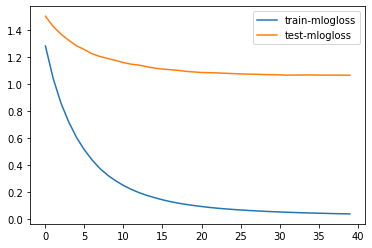

In [10]:
cv_results2 = xgb.cv(dtrain=dataset, 
                    params=xgb_params, 
                    nfold=2,
                    num_boost_round=50, 
                    early_stopping_rounds=5, 
                    metrics='mlogloss', as_pandas=True, seed=1337)  



2 Folds Results
Train logloss mean = 0.23186518750000001
Test logloss mean = 1.1389343375


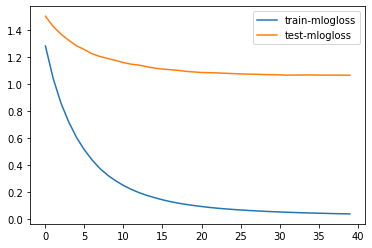

In [21]:
#Examine the results
print("2 Folds Results")
print("Train logloss mean =", cv_results2["train-mlogloss-mean"].mean())
print("Test logloss mean =", cv_results2["test-mlogloss-mean"].mean())
df_cv = pd.DataFrame({
   'train-mlogloss': cv_results2["train-mlogloss-mean"],
   'test-mlogloss':cv_results2["test-mlogloss-mean"]
   }, index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39])
lines = df_cv.plot.line()

In [ ]:
cv_results3 = xgb.cv(dtrain=dataset, 
                    params=xgb_params, 
                    nfold=3,
                    num_boost_round=50, 
                    early_stopping_rounds=5, 
                    metrics='mlogloss', as_pandas=True, seed=1337)  

In [ ]:
#Examine the results at kfold=3
print("3 Folds Results")
print("Train logloss mean =", cv_results3["train-mlogloss-mean"].mean())
print("Test logloss mean =", cv_results3["test-mlogloss-mean"].mean())
df_cv_3 = pd.DataFrame({
   'train-mlogloss': cv_results3["train-mlogloss-mean"],
   'test-mlogloss':cv_results3["test-mlogloss-mean"]
   }, index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39])
lines = df_cv_3.plot.line()